#  Ideas for fitting code:

- pickle all FF objects

In [1]:
%load_ext autoreload
%autoreload 2

from ff_energy.cli import load_config_maker, load_all_theory, charmm_jobs

# from ff_energy.structure import
from ff_energy.potential import FF, LJ, DE
import numpy as np
from ff_energy.data import Data, plot_ecol, plot_intE, plot_LJintE
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import pandas as pd
from ff_energy.utils import pickle_output, read_from_pickle
from ff_energy.data import Data

sig_bound = (0.25, 2.5)
ep_bound = (0.0001, 0.5)
LJ_bound = [(sig_bound), (sig_bound), (ep_bound), (ep_bound)]
DE_bound = [(sig_bound), (sig_bound), (ep_bound), (ep_bound), (4, 16), (4, 16)]
DE_bound

atom_key_pairs [('CG331', 'CG331'), ('CG331', 'HGA3'), ('CG331', 'HGP1'), ('CG331', 'HT'), ('CG331', 'OG311'), ('CG331', 'OT'), ('HGA3', 'HGA3'), ('HGA3', 'HGP1'), ('HGA3', 'HT'), ('HGA3', 'OG311'), ('HGA3', 'OT'), ('HGP1', 'HGP1'), ('HGP1', 'HT'), ('HGP1', 'OG311'), ('HGP1', 'OT'), ('HT', 'HT'), ('HT', 'OG311'), ('HT', 'OT'), ('OG311', 'OG311'), ('OG311', 'OT'), ('OT', 'OT')]
0 ('CG331', 'CG331')
1 ('CG331', 'HGA3')
2 ('CG331', 'HGP1')
3 ('CG331', 'HT')
4 ('CG331', 'OG311')
5 ('CG331', 'OT')
6 ('HGA3', 'HGA3')
7 ('HGA3', 'HGP1')
8 ('HGA3', 'HT')
9 ('HGA3', 'OG311')
10 ('HGA3', 'OT')
11 ('HGP1', 'HGP1')
12 ('HGP1', 'HT')
13 ('HGP1', 'OG311')
14 ('HGP1', 'OT')
15 ('HT', 'HT')
16 ('HT', 'OG311')
17 ('HT', 'OT')
18 ('OG311', 'OG311')
19 ('OG311', 'OT')
20 ('OT', 'OT')


[(0.25, 2.5), (0.25, 2.5), (0.0001, 0.5), (0.0001, 0.5), (4, 16), (4, 16)]

In [6]:
FUNC = DE
BOUNDS = DE_bound
ff_name = "pbe0dz_kmdcm"
structure = "water_cluster"
pk = "pickles/water_cluster/pbe0dz/pbe0_dz.kmdcm"


#########################################################

ff_pkls = Path("pickles/ff")
ff_pickles = ff_pkls.glob("*.pkl")
ff_pickles = [_.name for _ in ff_pickles]
struct_dist_pkls = Path("pickles/structures")
struct_dist_pickles = struct_dist_pkls.glob("*.pkl")
struct_dist_pickles = [_.name for _ in struct_dist_pickles]


pickled_ff = (ff_pkls / f"{ff_name}.pkl").exists()
pickled_dists = (struct_dist_pkls / f"{structure}.pkl").exists()
pickled_ff = False

if pickled_ff:
    print("Pickled FF exists!, loading: ", ff_pkls / f"{ff_name}.pkl")
    try:
        ff = next(read_from_pickle(ff_pkls / f"{ff_name}.pkl"))
    except StopIteration:
        print("Pickle read failed.")
        pickled_ff = False

if not pickled_ff:
    if pickled_dists:
        print("loading pickled distances/structure")
        structures, dists = next(
            read_from_pickle(f"pickles/structures/{structure}.pkl")
        )
    else:
        print("No pickled distances/structure information, calculating:")
        CMS = load_config_maker("pbe0dz", structure, "mdcm")
        jobs = charmm_jobs(CMS)
        dists = {_.name.split(".")[0]: _.distances for _ in jobs[0].structures}
        structures = [_ for _ in jobs[0].structures]
        pickle_output((structures, dists), name=f"structures/{structure}")

    s = structures[0]
    data_ = Data(pk)
    ff = FF(data_.data, dists, FUNC, BOUNDS, s)

# d = ff.data_save.sample(200)
# ff.data = d.copy()
# args = [1.7682,0.2245,-0.1521,-0.0460]
args = [1.7682, 0.2245, -0.1521, -0.0460, 7, 14]

loading pickled distances/structure
loading pickles from  pickles/water_cluster/pbe0dz/pbe0_dz.kmdcm
[('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
0 ('HT', 'HT') ('HT', 'HT')
1 ('HT', 'OT') ('HT', 'OT')
2 ('OT', 'OT') ('OT', 'OT')


In [7]:
print(len(ff.dists["test0"][15]))
print(len(ff.dists["test0"][17]))
print(len(ff.dists["test0"][20]))

190
380
190


In [8]:
# ff.data = ff.data_save
ff.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,n_pairs,intE,P_intE
test467,-113.436686,test467,22.56645,-64.08560,14.82881,test467,-1527.154217,test467,20,-1527.236629,190,-51.714066,-50.297664
test263,NaN,test263,21.29141,-92.76477,20.54380,test263,-1527.156016,test263,20,-1527.258259,190,-64.157783,-66.601357
test35,NaN,test35,23.43646,-87.37824,11.05221,test35,-1527.143158,test35,20,-1527.258584,189,-72.430230,-65.790457
test223,NaN,test223,24.37323,-47.13218,6.72946,test223,-1527.147556,test223,20,-1527.203106,190,-34.857221,-39.243367
test254,NaN,test254,27.07465,-90.75359,21.85417,test254,-1527.135568,test254,20,-1527.237145,188,-63.739697,-57.830990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
test100,-120.244324,test100,25.63059,-66.67887,19.45476,test100,-1527.141372,test100,20,-1527.210157,190,-43.162995,-42.125801
test304,NaN,test304,23.20412,-72.62700,17.28253,test304,-1527.150985,test304,20,-1527.239633,189,-55.626955,-54.710834
test327,NaN,test327,21.75196,-117.28678,31.12436,test327,-1527.154084,test327,20,-1527.300559,190,-91.913853,-79.340573
test185,-114.232038,test185,25.65796,-69.10066,11.20177,test185,-1527.144999,test185,20,-1527.232387,190,-54.835874,-54.451833


500
Index(['ECOL', 'KEY', 'TOTAL', 'ELEC', 'VDW', 'KEY', 'M_ENERGY', 'KEY',
       'n_monomers', 'C_ENERGY', 'n_pairs', 'intE', 'P_intE', 'LJ',
       'VDW_ERROR', 'VDW_SE', 'nb_intE', 'SE'],
      dtype='object')
18
31.09291763089988


,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,n_pairs,intE,P_intE,LJ,VDW_ERROR,VDW_SE,nb_intE,SE
test467,-113.436686,test467,22.56645,-64.08560,14.82881,test467,-1527.154217,test467,20,-1527.236629,190,-51.714066,-50.297664,19.922197,-5.093387,25.942588,-49.25679,57.012505
test263,NaN,test263,21.29141,-92.76477,20.54380,test263,-1527.156016,test263,20,-1527.258259,190,-64.157783,-66.601357,27.000749,-6.456949,41.692196,-72.22097,2.579999
test35,NaN,test35,23.43646,-87.37824,11.05221,test35,-1527.143158,test35,20,-1527.258584,189,-72.430230,-65.790457,16.825154,-5.772944,33.326882,-76.32603,3.523670
test223,NaN,test223,24.37323,-47.13218,6.72946,test223,-1527.147556,test223,20,-1527.203106,190,-34.857221,-39.243367,11.568409,-4.838949,23.415429,-40.40272,0.499213
test254,NaN,test254,27.07465,-90.75359,21.85417,test254,-1527.135568,test254,20,-1527.237145,188,-63.739697,-57.830990,27.979689,-6.125519,37.521978,-68.89942,0.932760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test100,-120.244324,test100,25.63059,-66.67887,19.45476,test100,-1527.141372,test100,20,-1527.210157,190,-43.162995,-42.125801,24.441706,-4.986946,24.869631,-47.22411,0.857163
test304,NaN,test304,23.20412,-72.62700,17.28253,test304,-1527.150985,test304,20,-1527.239633,189,-55.626955,-54.710834,22.499874,-5.217344,27.220673,-55.34447,30.248113
test327,NaN,test327,21.75196,-117.28678,31.12436,test327,-1527.154084,test327,20,-1527.300559,190,-91.913853,-79.340573,37.724469,-6.600109,43.561437,-86.16242,152.560594
test185,-114.232038,test185,25.65796,-69.10066,11.20177,test185,-1527.144999,test185,20,-1527.232387,190,-54.835874,-54.451833,16.213977,-5.012207,25.122223,-57.89889,3.799349


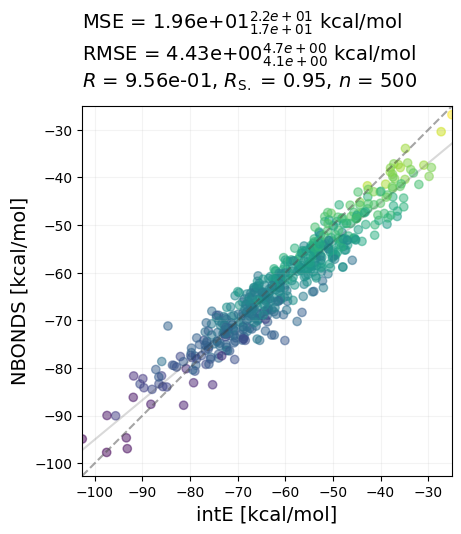

In [9]:
for i in range(1):
    # d = ff.data_save.sample(100)
    # ff.data = d.copy()
    print(len(ff.data))
    _ = ff.LJ_performace(ff.eval_func(args))
    print(_.keys())
    print(len(_.keys()))
    # _["nb_intE"] = _["NBONDS"]
    plot_intE(_)
    print(_["SE"].mean())
_

In [10]:
_["VDW_ERROR"].mean()

-5.685199274766864

In [11]:
# plot_intE(_)
ff.data_save["LJX"] = ff.data_save["intE"] - ff.data_save["ELEC"]

ff.data_save.sort_values("LJX")[0:-250]

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,n_pairs,intE,P_intE,LJX
test82,NaN,test82,27.40814,-41.26657,-0.47355,test82,-1527.133519,test82,20,-1527.201649,190,-42.751560,-43.484137,-1.484990
test387,NaN,test387,18.28247,-64.27816,5.10084,test387,-1527.168269,test387,20,-1527.267636,190,-62.352771,-57.569536,1.925389
test94,NaN,test94,25.31759,-71.91358,7.94835,test94,-1527.140309,test94,20,-1527.251793,190,-69.956651,-64.839330,1.956929
test277,NaN,test277,20.06028,-87.95185,9.31564,test277,-1527.160446,test277,20,-1527.297392,186,-85.934252,-75.905983,2.017598
test257,NaN,test257,23.79242,-52.41728,4.90190,test257,-1527.148169,test257,20,-1527.228414,190,-50.354003,-48.740460,2.063277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test314,NaN,test314,22.95076,-91.65230,17.21379,test314,-1527.147437,test314,20,-1527.265819,186,-74.285154,-71.516997,17.367146
test208,NaN,test208,24.74110,-74.10804,14.54679,test208,-1527.144888,test208,20,-1527.235267,190,-56.712818,-52.269413,17.395222
test480,NaN,test480,22.42139,-89.34334,17.77812,test480,-1527.154639,test480,20,-1527.269293,190,-71.945641,-68.276851,17.397699
test413,NaN,test413,25.82918,-103.38242,21.73522,test413,-1527.144045,test413,20,-1527.281057,190,-85.975184,-79.926319,17.407236


In [12]:
ff.opt_results, ff.opt_results_df = [], []
for i in range(2):
    d = ff.data_save.sort_values("LJX")[10:-10].sample(250)
    ff.data = d.copy()
    ff.fit_repeat(1, bounds=DE_bound)
pickle_output(ff, "ff/pbe0dz_mdcm")

Optimizing LJ parameters...
function: DE
bounds: [(0.25, 2.5), (0.25, 2.5), (0.0001, 0.5), (0.0001, 0.5), (4, 16), (4, 16)]
maxfev: 10000
initial guess: [2.347995328485499, 2.1387177585462585, 0.26410776999366825, 0.48790445664191817, 14.915112220079543, 14.490553001127791]


/home/boittier/Documents/phd/ff_energy/ff_energy/potential.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  return e * (((b * np.exp(a)) / (a - b)) * np.exp(-a * (x / c))
/home/boittier/Documents/phd/ff_energy/ff_energy/potential.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  - ((a * np.exp(b)) / (a - b)) * np.exp(-b * (x / c)))
/home/boittier/Documents/phd/ff_energy/ff_energy/potential.py:42: RuntimeWarning: invalid value encountered in subtract
  return e * (((b * np.exp(a)) / (a - b)) * np.exp(-a * (x / c))
/home/boittier/Documents/phd/ff_energy/ff_energy/potential.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  return e * (((b * np.exp(a)) / (a - b)) * np.exp(-a * (x / c))
/home/boittier/Documents/phd/ff_energy/ff_energy/potential.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  - ((a * np.exp(b)) / (a - b)) * np.exp(-b * (x / c)))
/home/boittier/Documents/phd/ff_energy/ff_energy/potential.py:42: Run

final_loss_fn:  15.192071346424447
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 15.192071346424447
             x: [ 1.981e+00  2.500e-01  5.854e-02  5.000e-01  4.000e+00
                  1.408e+01]
           nit: 662
          nfev: 1073
 final_simplex: (array([[ 1.981e+00,  2.500e-01, ...,  4.000e+00,
                         1.408e+01],
                       [ 1.981e+00,  2.500e-01, ...,  4.000e+00,
                         1.408e+01],
                       ...,
                       [ 1.981e+00,  2.500e-01, ...,  4.000e+00,
                         1.408e+01],
                       [ 1.981e+00,  2.500e-01, ...,  4.000e+00,
                         1.408e+01]]), array([ 1.519e+01,  1.519e+01,  1.519e+01,  1.519e+01,
                        1.519e+01,  1.519e+01,  1.519e+01]))
Set optimized parameters to FF object, self.df["LJ"] is updated.
Set optimized parameters to FF object, use FF.opt_parm to get the optimized

In [13]:
pd.DataFrame(ff.opt_results)

,fun,nit,nfev,status,success,message,x,final_simplex
0,15.192071,662,1073,0,True,Optimization terminated successfully.,"[1.9807628249055367, 0.25, 0.05853861593609239...","([[1.9807628249055367, 0.25, 0.058538615936092..."
1,18.769285,6547,10000,1,False,Maximum number of function evaluations has bee...,"[1.8422067288000055, 1.3804319003838548, 0.000...","([[1.8422067288000055, 1.3804319003838548, 0.0..."


In [46]:
print(len(ff.data))
# plot_intE(ff.get_best_df())

250


In [47]:
results = pd.DataFrame(ff.opt_results)
best_func = results.sort_values("fun")[:10]
best_func

,fun,nit,nfev,status,success,message,x,final_simplex
8,15.054330,811,1268,0,True,Optimization terminated successfully.,"[1.7704194423482882, 0.25, 0.15008754502390026...","([[1.7704194423482882, 0.25, 0.150087545023900..."
7,15.279884,548,846,0,True,Optimization terminated successfully.,"[1.7955656933664583, 0.25, 0.11792882308218797...","([[1.7955656933664583, 0.25, 0.117928823082187..."
9,15.419176,1208,1848,0,True,Optimization terminated successfully.,"[1.8088140982208452, 0.2500000006694305, 0.101...","([[1.8088140982208452, 0.2500000006694305, 0.1..."
3,16.857894,2479,3890,0,True,Optimization terminated successfully.,"[2.062475734574116, 1.8910046497413955, 0.0001...","([[2.062475734574116, 1.8910046497413955, 0.00..."
5,18.938102,2041,3196,0,True,Optimization terminated successfully.,"[2.0544985211523605, 1.8882746592883817, 0.000...","([[2.0544985211523605, 1.8882746592883817, 0.0..."
2,24.229976,625,1030,0,True,Optimization terminated successfully.,"[1.691374356343995, 0.25, 0.5, 0.0001000000000...","([[1.691374356343995, 0.25, 0.5, 0.00010000000..."
1,346.536175,99,234,0,True,Optimization terminated successfully.,"[0.25, 0.25, 0.0001, 0.0001, 16.0, 4.0]","([[0.25, 0.25, 0.0001, 0.0001, 16.0, 4.0], [0...."
4,360.971155,117,305,0,True,Optimization terminated successfully.,"[0.25, 0.25, 0.0001, 0.00010000000000000235, 4...","([[0.25, 0.25, 0.0001, 0.00010000000000000235,..."
0,361.351163,100,243,0,True,Optimization terminated successfully.,"[0.25, 0.25, 0.0001, 0.00010000000000000151, 4...","([[0.25, 0.25, 0.0001, 0.00010000000000000151,..."
6,370.061624,88,254,0,True,Optimization terminated successfully.,"[0.25, 0.25, 0.0001, 0.0001, 4.0, 16.0]","([[0.25, 0.25, 0.0001, 0.0001, 4.0, 16.0], [0...."


In [48]:
x = best_func["x"]
values = []

for _ in x:
    epsig = ["$\sigma$", "$\epsilon$"]
    names = []
    for es in epsig:
        for at in ff.atom_types:
            names.append(at + es)
    values.append({names[i]: _[i] for i in range(len(_))})


values = pd.DataFrame(values)
values["rmse"] = best_func["fun"]

# values.plot("rmse")

IndexError: list index out of range

29.2 (250) 24.2 (250)


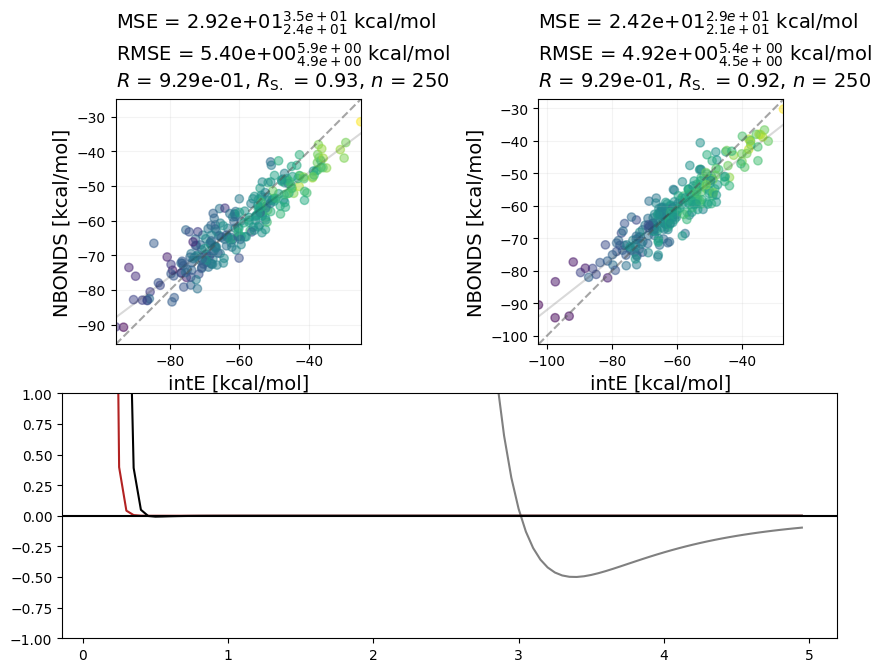

26.0 (250) 16.9 (250)


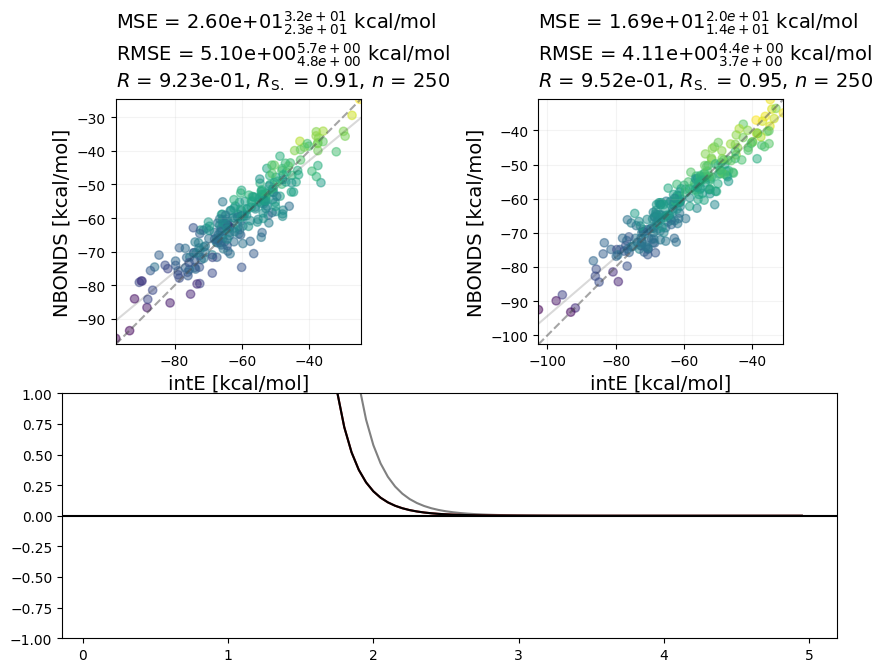

24.1 (250) 18.9 (250)


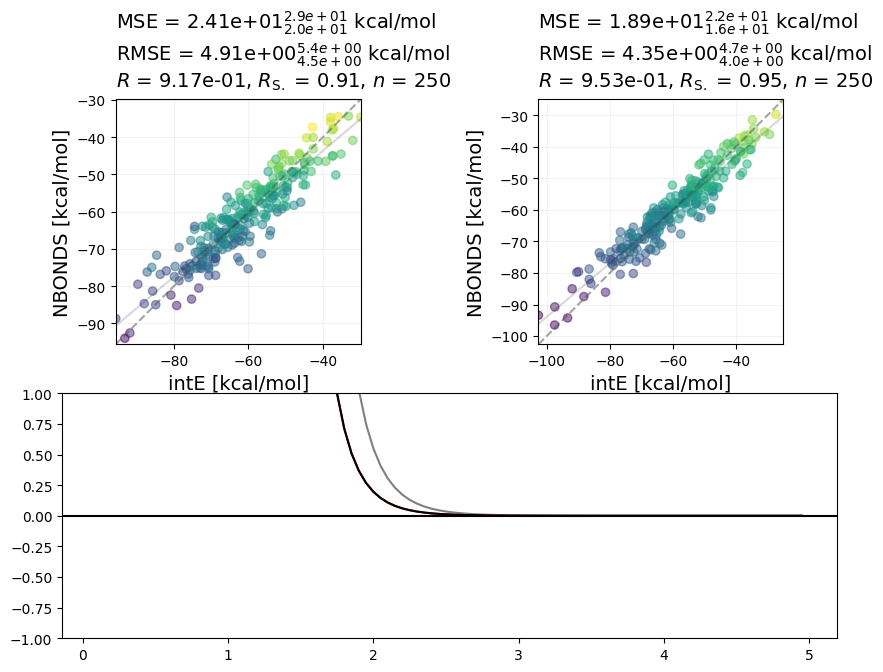

17.3 (250) 15.3 (250)


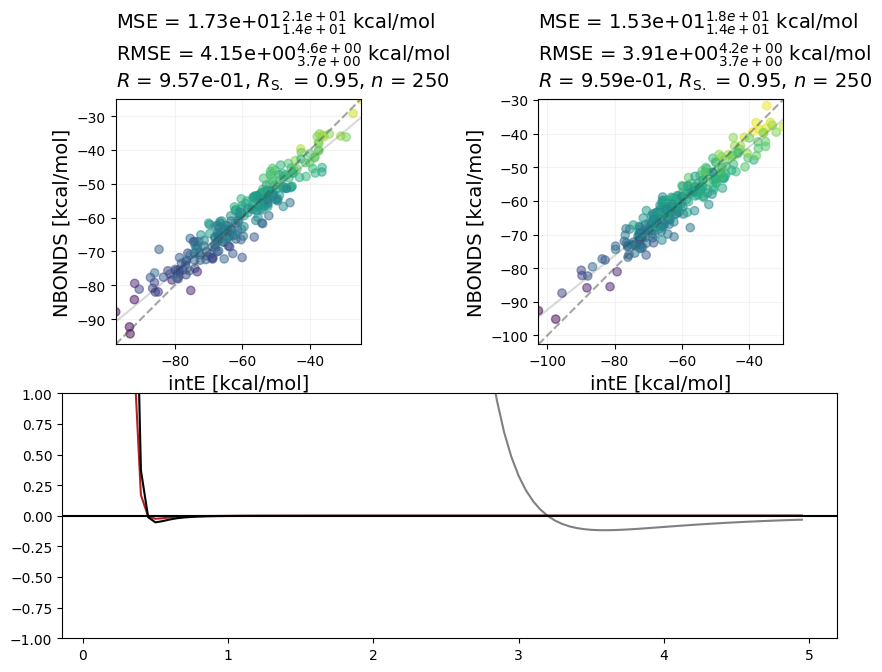

17.6 (250) 15.1 (250)


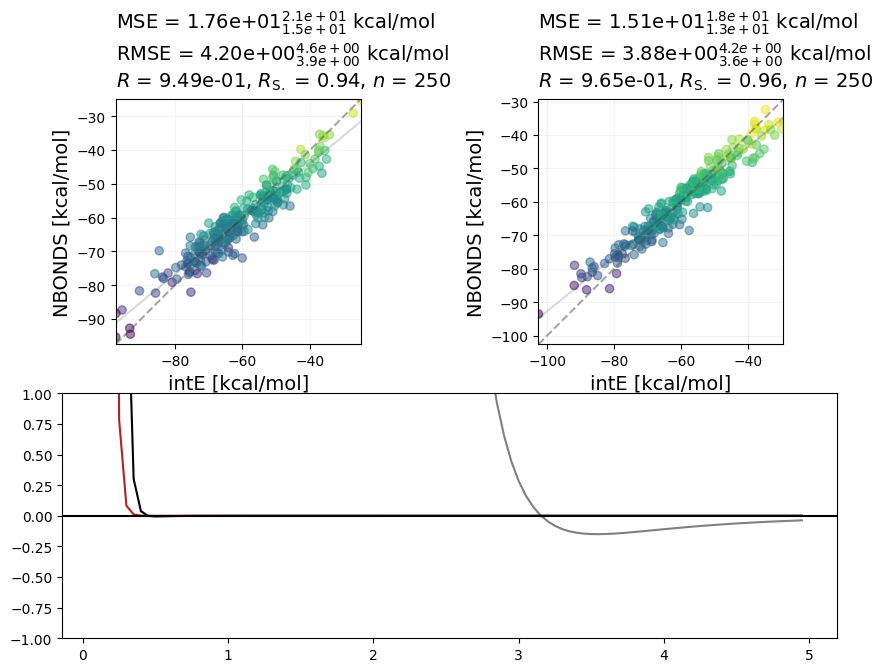

17.4 (250) 15.4 (250)


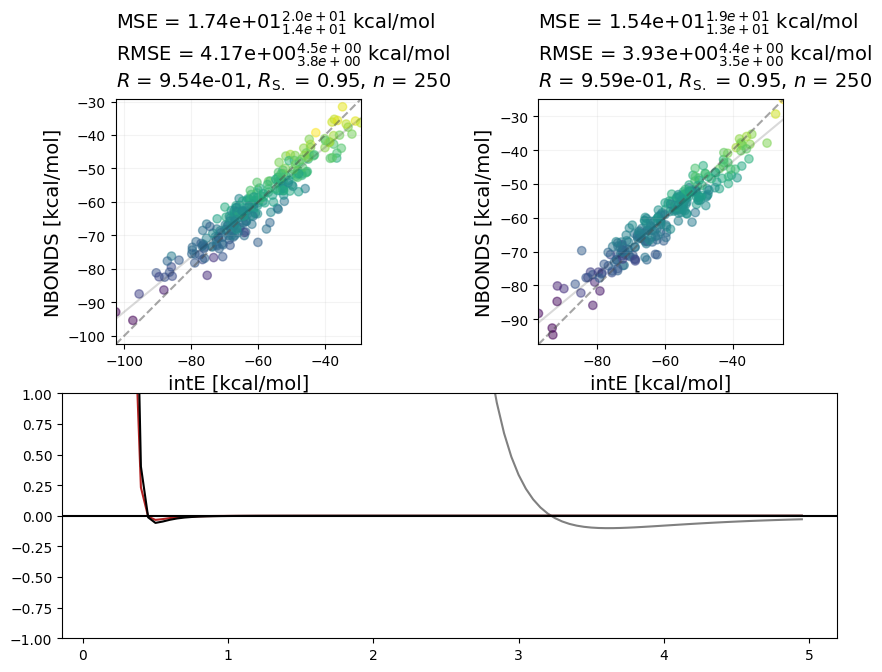

In [49]:
test_ = []
train_ = []
args_ = []
dfs_ = []

for res, data in zip(ff.opt_results, ff.opt_results_df):
    if res["fun"] < 30:
        test_keys = [_ for _ in list(ff.data_save.index) if _ not in data.index]
        test_df = ff.data_save.query("index in @test_keys")
        ff.data = test_df.copy()
        test_len = len(ff.data)
        test_res = ff.LJ_performace(ff.eval_func(res.x))

        # fig, ax = plt.subplots(1,3,figsize=(15,15))
        fig, ax = plt.subplot_mosaic([[0, 1], [2, 2]], figsize=(10, 7))

        plot_LJintE(test_res, ax=ax[0])

        ff.data = ff.data_save.query("index not in @test_keys").copy()
        train_len = len(ff.data)
        train_res = ff.LJ_performace(ff.eval_func(res.x))
        plot_LJintE(train_res, ax=ax[1])
        print(
            "{:.1f} ({}) {:.1f} ({})".format(
                test_res["SE"].mean(), test_len, train_res["SE"].mean(), train_len
            )
        )

        res = res.x
        x = np.arange(0.1, 5, 0.05)
        y = LJ(res[0] * 2, res[2], x)
        ax[2].plot(x, y, c="grey")
        y = LJ(res[1] * 2, res[3], x)
        ax[2].plot(x, y, c="firebrick")
        y = LJ(res[1] + res[1], np.sqrt(res[3] * res[2]), x)
        ax[2].plot(x, y, c="k")

        ax[2].axhline(0, c="k")
        ax[2].set_ylim(-1, 1)
        plt.show()

        test_.append(test_res["SE"].mean())
        train_.append(train_res["SE"].mean())
        args_.append(res)
        dfs_.append(test_res)

In [15]:
# for _ in best_func.iterrows():
#     i, _ = _
#     # print(_)
#     res = _["x"]
#     fun = _["fun"]
#     plt.title(f"{fun} {res}")
#     x = np.arange(0.1,5,0.05)
#     y = LJ(res[0]*2,res[2],x)
#     plt.plot(x, y, c="grey")
#     y = LJ(res[1]*2,res[3],x)
#     plt.plot(x, y, c="firebrick")
#     y = LJ(res[1]+res[1],np.sqrt(res[3]*res[2]),x)
#     plt.plot(x, y, c="k")


#     plt.axhline(0,c="k")
#     plt.ylim(-1,1)
#     plt.show()

In [27]:
df = pd.DataFrame({"test": test_, "train": train_, "args": args_, "df": dfs_})

In [33]:
best = df[df["train"] < 35]
# best["test"] = np.sqrt(best["test"])
# best["train"] = np.sqrt(best["train"])
best

,test,train,args,df
0,25.416309,26.507449,"[0.5034362263464525, 2.055311696715542, 0.0028...",ECOL KEY TOTAL E...
3,24.618123,26.679160,"[1.0797728771126858, 2.0538225742127643, 1.000...",ECOL KEY TOTAL E...
5,24.645220,26.722080,"[0.6141949734244336, 2.0720173552800727, 0.000...",ECOL KEY TOTAL E...
8,24.618123,26.679160,"[1.079773090487658, 2.0538210705069204, 1e-05,...",ECOL KEY TOTAL E...
9,24.951449,27.107474,"[0.5, 1.9877123349914758, 1.0000000000000003e-...",ECOL KEY TOTAL E...
13,24.341779,27.929212,"[0.5, 1.9657947176660302, 1.0000000000000341e-...",ECOL KEY TOTAL EL...
16,24.341779,27.929212,"[0.5, 1.9657948300415828, 1.0000000000000016e-...",ECOL KEY TOTAL EL...
17,25.156794,28.093869,"[0.6258432366956577, 3.8232148246761435, 2.643...",ECOL KEY TOTAL EL...
19,24.477932,27.465470,"[0.9634967999409443, 1.9632706069085946, 2.380...",ECOL KEY TOTAL EL...
20,24.385674,27.340309,"[0.5422799060961985, 2.064181479237102, 0.0015...",ECOL KEY TOTAL EL...


In [34]:
best.iloc[0]["df"]

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,n_pairs,intE,P_intE,LJ,VDW_ERROR,VDW_SE,nb_intE,SE
test467,-113.436686,test467,21.39109,-81.32190,14.82881,test467,-1527.154217,test467,20,-1527.236629,190,-51.714066,-50.297664,40.255371,-25.426561,646.509989,-41.066529,113.370035
test263,-16.820533,test263,19.20382,-122.03878,20.54380,test263,-1527.156016,test263,20,-1527.258259,190,-64.157783,-66.601357,53.149059,-32.605259,1063.102928,-68.889721,22.391236
test35,-25.924214,test35,22.25853,-100.65197,11.05221,test35,-1527.143158,test35,20,-1527.258584,189,-72.430230,-65.790457,35.329966,-24.277756,589.409453,-65.322004,50.526886
test254,-1.846755,test254,22.63732,-124.82730,21.85417,test254,-1527.135568,test254,20,-1527.237145,188,-63.739697,-57.830990,53.337429,-31.483259,991.195579,-71.489871,60.065209
test478,-8.347594,test478,20.57061,-137.04099,17.44172,test478,-1527.139702,test478,20,-1527.283906,190,-90.488888,-80.561487,47.238588,-29.796868,887.853365,-89.802402,0.471264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test191,NaN,NaN,21.63254,-110.06365,20.86924,test191,-1527.149787,test191,20,-1527.249170,190,-62.362955,-62.290388,50.888888,-30.019648,901.179269,-59.174762,10.164575
test285,NaN,NaN,21.83160,-110.69072,22.43307,test285,-1527.147466,test285,20,-1527.242580,190,-59.684113,-58.592499,53.616376,-31.183306,972.398582,-57.074344,6.810896
test204,NaN,NaN,17.66112,-129.14115,28.88785,test204,-1527.157200,test204,20,-1527.272753,190,-72.510080,-65.943128,63.417300,-34.529450,1192.282932,-65.723850,46.052921
test486,NaN,NaN,26.64222,-110.79449,25.86481,test486,-1527.123959,test486,20,-1527.198832,190,-46.983584,-46.456197,58.367343,-32.502533,1056.414625,-52.427147,29.632379


Text(0, 0.5, 'Train')

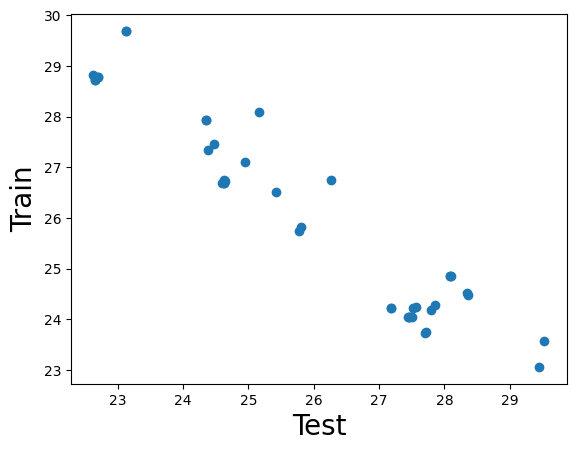

In [35]:
plt.scatter(best["test"], best["train"])
plt.xlabel("Test", fontsize=20)
plt.ylabel("Train", fontsize=20)

In [36]:
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.pyplot as plt

# # Prepare the data for the PathPatch below.
# Path = mpath.Path
# codes, verts = zip(*[
#     (Path.MOVETO, [0.018, -0.11]),
#     (Path.CURVE4, [-0.031, -0.051]),
#     (Path.CURVE4, [-0.115, 0.073]),
#     (Path.CURVE4, [-0.03, 0.073]),
#     (Path.LINETO, [-0.011, 0.039]),
#     (Path.CURVE4, [0.043, 0.121]),
#     (Path.CURVE4, [0.075, -0.005]),
#     (Path.CURVE4, [0.035, -0.027]),
#     (Path.CLOSEPOLY, [0.018, -0.11])])

# artists = [
#     mpatches.Circle((0, 0), 0.1, ec="none"),
#     mpatches.Rectangle((-0.025, -0.05), 0.05, 0.1, ec="none"),
#     mpatches.Wedge((0, 0), 0.1, 30, 270, ec="none"),
#     mpatches.RegularPolygon((0, 0), 5, radius=0.1),
#     mpatches.Ellipse((0, 0), 0.2, 0.1),
#     mpatches.Arrow(-0.05, -0.05, 0.1, 0.1, width=0.1),
#     mpatches.PathPatch(mpath.Path(verts, codes), ec="none"),
#     mpatches.FancyBboxPatch((-0.025, -0.05), 0.05, 0.1, ec="none",
#                             boxstyle=mpatches.BoxStyle("Round", pad=0.02)),
#     mlines.Line2D([-0.06, 0.0, 0.1], [0.05, -0.05, 0.05], lw=5),
# ]

# axs = plt.figure(figsize=(6, 6), layout="constrained").subplots(3, 3)
# for i, (ax, artist) in enumerate(zip(axs.flat, artists)):
#     artist.set(color=mpl.colormaps["hsv"](i / len(artists)))
#     ax.add_artist(artist)
#     ax.set(title=type(artist).__name__,
#            aspect=1, xlim=(-.2, .2), ylim=(-.2, .2))
#     ax.set_axis_off()
# plt.show()

In [37]:
import seaborn as sns
import matplotlib as mpl

# cmap = sns.color_palette("icefire", as_cmap=True)
# # cmap()
# # cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)

# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal', label='Some Units')

In [38]:
# sns.choose_diverging_palette(as_cmap=True)

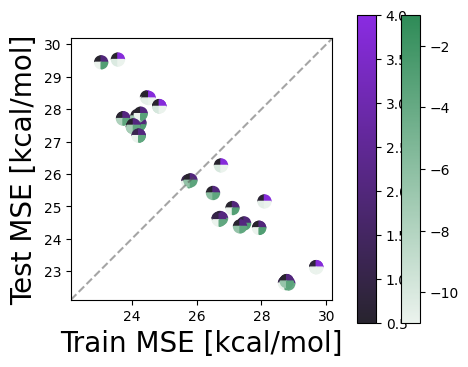

In [39]:
# cmap1 = sns.cubehelix_palette(start=.5, rot=-.99, as_cmap=True)
# cmap2 = sns.cubehelix_palette(start=.2, rot=-.99, as_cmap=True)
# cmap1 = sns.color_palette("Blues", as_cmap=True)
# cmap2 = sns.color_palette("Reds", as_cmap=True)
cmap1 = sns.color_palette("light:seagreen", as_cmap=True)
cmap2 = sns.color_palette("dark:blueviolet", as_cmap=True)


fig, ax = plt.subplots(
    1, 3, figsize=(4.5, 4), gridspec_kw={"width_ratios": [3.5, 0.25, 0.25]}
)

plt.subplots_adjust(wspace=0.25)

quarters = [
    (360, 90),
    (90, 180),
    (180, 270),
    (270, 360),
]


def plot_circle(x, y, ax, res):
    # print(res)
    size = 0.2
    quarters = [
        (90, 180),
        (0, 90),
        (180, 270),
        (270, 0),
    ]
    for i, (a, b) in enumerate(quarters):
        move = 0.0
        if i == 1:
            wedge = mpatches.Wedge((x, y), size, a, b)
        elif i == 0:
            wedge = mpatches.Wedge((x, y), size, a, b)
        elif i == 2:
            wedge = mpatches.Wedge((x, y + move), size, a, b)
        else:
            wedge = mpatches.Wedge((x, y + move), size, a, b)
        # wedge.set(color=mpl.colormaps["hsv"](i / 4))
        if i == 0 or i == 1:
            # print(res[i])
            cval = norm2(res[i])
            cmap = cmap2
        else:
            # print(res[i],np.log(res[i]))
            cval = norm1(np.log(res[i]))
            cmap = cmap1
        wedge.set(color=cmap(cval))
        if x < 27:
            wedge.set(alpha=1)
        ax.add_artist(wedge)
        # ax.set(aspect=1, xlim=(-.2, .2), ylim=(-.2, .2))
    return ax


norm1 = mpl.colors.Normalize(vmin=-11, vmax=-1)
norm2 = mpl.colors.Normalize(vmin=0.5, vmax=4)


# plt.scatter(best["test"], best["train"])
ax[0].set_xlabel("Train MSE [kcal/mol]", fontsize=20)
ax[0].set_ylabel("Test MSE [kcal/mol]", fontsize=20)
# plt.colorbar(cmap)
# plt.gca().set_axis_off()
minlim = min([best["test"].min(), best["train"].min()]) - 0.5
maxlim = max([best["test"].max(), best["train"].max()]) + 0.5

plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2),
    cax=ax[1],
    orientation="vertical",
    label="",
)
plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm1, cmap=cmap1),
    cax=ax[2],
    orientation="vertical",
    label="",
)

for x, y, res in zip(best["train"], best["test"], best["args"]):
    ax[0] = plot_circle(x, y, ax[0], res)

ax[0].set_xlim(minlim, maxlim)
ax[0].set_ylim(minlim, maxlim)
# ax[0].set_ylim(25, 29.5)
ax[0].plot(ax[0].get_xlim(), ax[0].get_ylim(), ls="--", c=".3", alpha=0.5)
# ax[0].grid()
ax[0].set_aspect(1)
plt.savefig("test.pdf", bbox_inches="tight")
plt.show()

In [85]:
from scipy.stats import bootstrap

rng = np.random.default_rng()


def boot_strap(best_res):
    data = (best_res["SE"],)  # samples must be in a sequence
    res = bootstrap(
        data, np.mean, confidence_level=0.95, random_state=rng, n_resamples=99999
    )
    print([np.sqrt(_) for _ in [data[0].mean(), *res.confidence_interval]])
    print()
    # plt.hist(data)
    # fig, ax = plt.subplots()
    # ax.hist(res.bootstrap_distribution, bins=10)
    # ax.set_title('Bootstrap Distribution')
    # ax.set_xlabel('statistic value')
    # ax.set_ylabel('frequency')
    # plt.show()


for i in range(len(best)):
    print(i, best.iloc[i]["args"])
    best_res = best.iloc[i]["df"]
    boot_strap(best_res)

0 [2.18863786e+00 5.01979202e-01 1.16221449e-02 1.22542465e-03]
[5.258061222834217, 4.928240162017293, 5.635217518595031]

1 [2.05267978e+00 5.00000000e-01 2.92584087e-02 7.26318017e-04]
[5.250615725798329, 4.919723098726593, 5.629031679447502]

2 [2.05216402e+00 5.05536295e-01 2.93561785e-02 6.86727574e-04]
[5.250552365419344, 4.918093328179624, 5.631758994170619]

3 [2.25556410e+00 5.00000000e-01 7.70712169e-03 1.22067537e-03]
[5.265355813602289, 4.931998169601272, 5.645641353337261]

4 [3.82891951e+00 5.50109668e-01 1.05486861e-05 2.31341006e-05]
[5.318294417937005, 4.984492116330265, 5.702409263123657]

5 [3.31948549e+00 5.00000000e-01 6.80701626e-05 1.78830950e-05]
[5.2640102539490705, 4.935025932065009, 5.634261667303115]

6 [2.14903312e+00 5.00000000e-01 1.66227038e-02 1.00000000e-05]
[5.193120434580334, 4.870002152641806, 5.56438119335041]

7 [2.14967099e+00 5.06719922e-01 1.65505576e-02 1.00000000e-05]
[5.192891077974372, 4.8684860741072695, 5.565759008970995]

8 [2.14903247e+

27.64720782307286 24.257214295913368 31.681689168314147


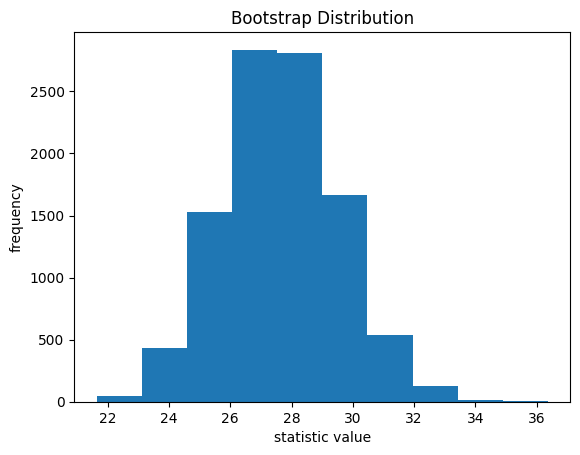